In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.10.1


In [30]:
def plot_series(time, series, format="--", start = 0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]) )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
    

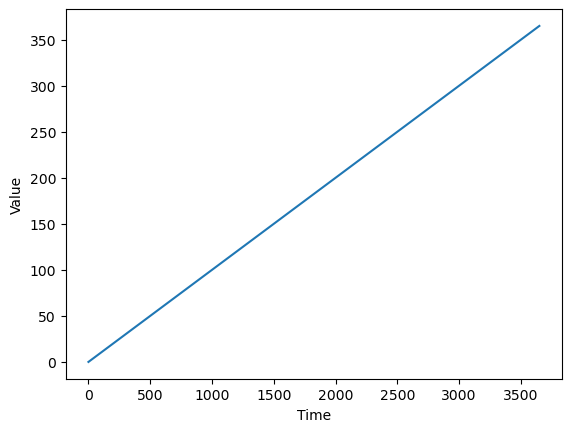

In [6]:
# create the data
time =  np.arange(10*365, dtype = "float32")
slope = 0.1
series = time * slope
plot_series(time, series)


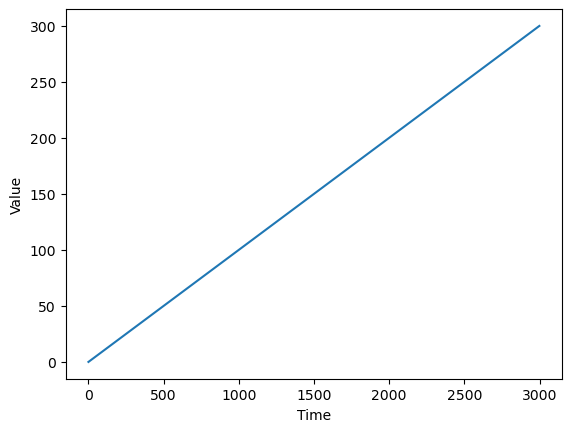

In [7]:
#split the data into training and validation
split_time = 3000
time_train = time[:split_time]
time_valid = time[split_time:]
x_train = series[:split_time]
x_valid = series[split_time:]
plot_series(time_train, x_train)




In [12]:
#prepare window size, batch size
window_size = 10
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [13]:
l0 = tf.keras.layers.Dense(1, input_shape =[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))

In [19]:
model.fit(dataset, epochs=5, verbose = 1)

Epoch 1/5
94/94 [==============================] - 1s 4ms/step - loss: 0.0441
Epoch 2/5
94/94 [==============================] - 0s 3ms/step - loss: 0.0432
Epoch 3/5
94/94 [==============================] - 0s 4ms/step - loss: 0.0447
Epoch 4/5
94/94 [==============================] - 0s 3ms/step - loss: 0.0435
Epoch 5/5
94/94 [==============================] - 0s 3ms/step - loss: 0.0426


In [20]:
print("Layer weights\n{}".format(l0.get_weights()))

Layer weights
[array([[-0.13688117],
       [ 0.20974427],
       [-0.417394  ],
       [ 0.778179  ],
       [ 0.10366061],
       [-0.24094595],
       [ 0.45480973],
       [-0.08827173],
       [ 0.6712356 ],
       [-0.33250502]], dtype=float32), array([0.00743575], dtype=float32)]


In [22]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis], verbose=0))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

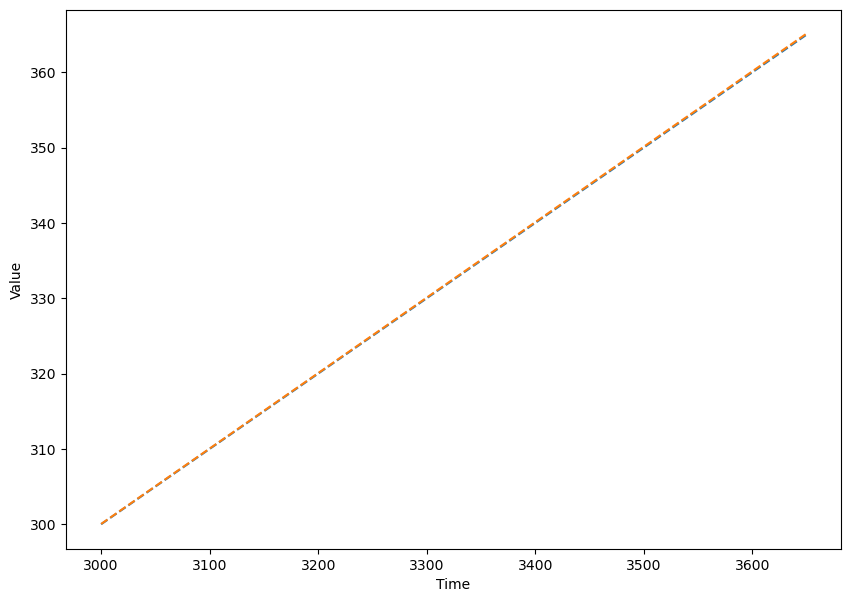

In [31]:
plt.figure(figsize = (10,7))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.08892174